In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
import matplotlib as mpl
from sklearn.linear_model import Ridge
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import matplotlib.cm as cm

import ResidualDecomposition as RD

np.random.seed(0)

In [2]:
data = pd.read_csv("Datasets/P_Dilute_Solute_Diffusion_with_features.csv").iloc[:,1:]
Y = data['E_raw (eV)']
X = data.iloc[:,4:]

data.head(5)

,Material compositions 1,Material compositions 2,Enorm (eV),E_raw (eV),Site2_MeltingT,Site1_MendeleevNumber,Site1_MiracleRadius,GSestFCClatcnt_max_value,Site2_BCCenergy_pa,Site1_BCCfermi,...,BCCenergy_pa_composition_average,MiracleRadius_min_value,MeltingT_min_value,NUnfilled_max_value,Site2_Group,Site1_CovalentRadii,Site2_NUnfilled,SpecificHeatCapacity_difference,Site1_Electronegativity,BCCenergy_pa_arithmetic_average
0,Ag,Ag,0.000000,1.824450,0.289137,0.783784,0.25,0.17956,0.799972,0.171595,...,0.844644,0.424242,0.289137,0.045455,0.666667,0.322034,0.045455,0.000000,0.603896,0.844644
1,Ag,Co,-0.090142,1.734308,0.443173,0.783784,0.25,0.17956,0.467125,0.171595,...,0.668927,0.232323,0.289137,0.136364,0.533333,0.322034,0.136364,0.072600,0.603896,0.668927
2,Ag,Cr,0.259139,2.083589,0.562225,0.783784,0.25,0.17956,0.269865,0.171595,...,0.564790,0.282828,0.289137,0.272727,0.333333,0.322034,0.272727,0.083528,0.603896,0.564790
3,Ag,Cu,-0.022200,1.802250,0.324633,0.783784,0.25,0.17956,0.727864,0.171595,...,0.806577,0.242424,0.289137,0.045455,0.666667,0.322034,0.045455,0.058548,0.603896,0.806577
4,Ag,Fe,0.317672,2.142122,0.455598,0.783784,0.25,0.17956,0.365132,0.171595,...,0.615083,0.232323,0.289137,0.181818,0.466667,0.322034,0.181818,0.083528,0.603896,0.615083


We first demonstrate a simple straightforward machine learning pipeline to predict the target labels. We scale the data, and carry out a randomized CV search to determine the optimal parameters for the RF model.

In [3]:
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
distributions = dict(n_estimators=np.arange(10, 200, 10), max_depth=np.arange(2,50))
clf = RandomizedSearchCV(rf, distributions, n_iter=100, n_jobs=-1)
clf.fit(X, Y)
rf_best = clf.best_estimator_

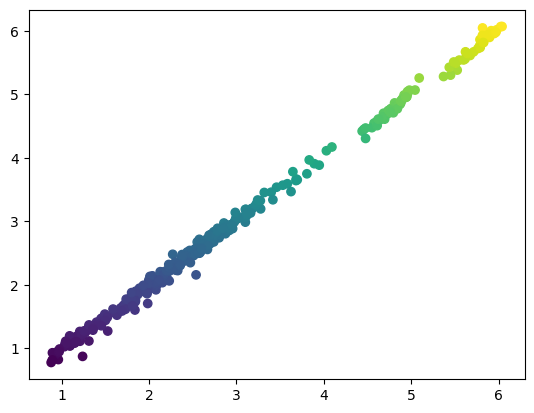

In [4]:
# Verify the model against the whole dataset

rf_best.fit(X, Y)

plt.scatter(rf_best.predict(X), Y, c=Y)

In [5]:
cvs = cross_val_score(rf_best, X, Y, cv=5, scoring="neg_mean_squared_error")
cv_score = np.mean(np.abs(cvs))
print("Average 5-fold CV MSE score is: {} eV".format(cv_score))

Average 5-fold CV MSE score is: 1.2206205772452694 eV


For the optimal model we plt the relative importance of each of the features in the following plot

Text(0, 0.5, 'Feature Descriptor')

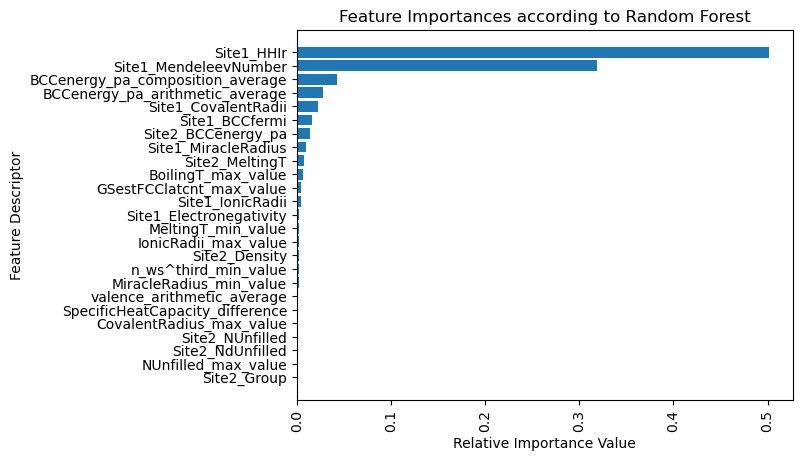

In [6]:
features_vals = np.sort(rf_best.feature_importances_)
features_args = np.argsort(rf_best.feature_importances_)

plt.xticks(rotation=90)
plt.barh(data.columns[4:][features_args], features_vals)
plt.title("Feature Importances according to Random Forest")
plt.xlabel("Relative Importance Value")
plt.ylabel("Feature Descriptor")

In [7]:
data_lr = np.genfromtxt("Data/LR_DSD.csv", delimiter=',')
data_lr_composition = data_lr
summed_composition = np.sum(data_lr_composition, axis=0)
data_lr_contribution = ((data_lr_composition.T * -np.sign(summed_composition))).T

data_rf = np.genfromtxt("Data/RF_DSD.csv", delimiter=',')
data_rf_composition = data_rf
summed_composition = np.sum(data_rf_composition, axis=0)
data_rf_contribution = ((data_rf_composition.T * -np.sign(summed_composition))).T

In [8]:
def plot_group(elements_subgroup, data_d, index_i):
    g1 = d[d.iloc[:,index_i].isin(elements_subgroup)].index
    g2 = d[~d.iloc[:,index_i].isin(elements_subgroup)].index
    # plt.xlabel("Composition Mean")
    # plt.ylabel("Contribution Mean")
    plt.axhline(0, c='r')
    plt.axvline(0, c='orange')
    plt.scatter(np.mean(data_rf_composition, axis=0)[g2], np.mean(data_rf_contribution, axis=1)[g2], c='b', s=10)
    plt.scatter(np.mean(data_rf_composition, axis=0)[g1], np.mean(data_rf_contribution, axis=1)[g1], c='r', s=10)

We plot the CC plots for the models LR and RF for the Dilute Solute Diffusion dataset below, it can be seen that the Random Forest model produces a more uniform CC-plot and should be a better choice of model than the LR model. 

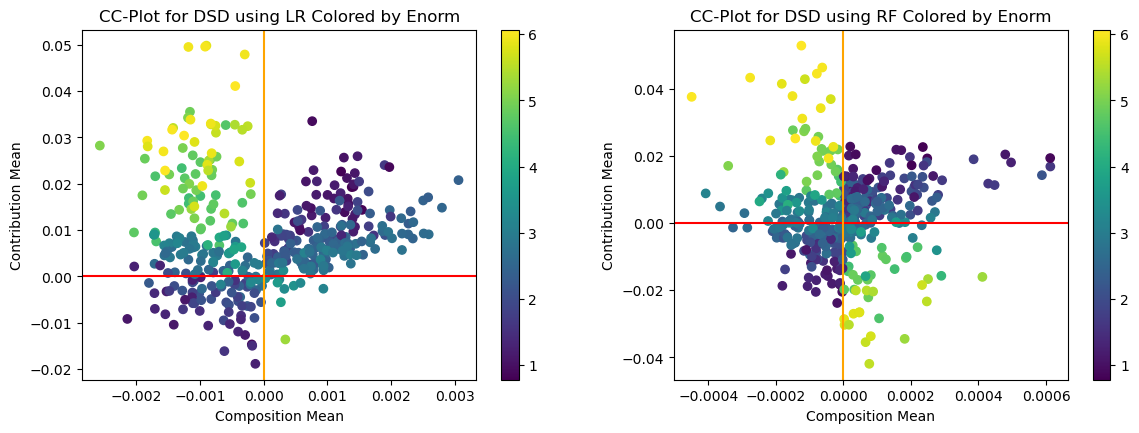

In [9]:
plt.figure(figsize=(14,10))

plt.subplot(221)

plt.title("CC-Plot for DSD using LR Colored by Enorm")
plt.xlabel("Composition Mean")
plt.ylabel("Contribution Mean")
plt.axhline(0, c='r')
plt.axvline(0, c='orange')
plt.scatter(np.mean(data_lr_composition, axis=0), np.mean(data_lr_contribution, axis=1), c=Y)
cbar = plt.colorbar()
cbar.ax.tick_params()

plt.subplot(222)

plt.title("CC-Plot for DSD using RF Colored by Enorm")
plt.xlabel("Composition Mean")
plt.ylabel("Contribution Mean")
plt.axhline(0, c='r')
plt.axvline(0, c='orange')
plt.scatter(np.mean(data_rf_composition, axis=0), np.mean(data_rf_contribution, axis=1), c=Y)

cbar = plt.colorbar()
cbar.ax.tick_params()

We detect and plot noteworthy outliers in the CC properties of the DSD data by means of outlier and clustering analysis

In [10]:
iforest = IsolationForest(n_estimators=100, n_jobs=-1)
iforest_outliers_rf = iforest.fit_predict(data_rf_composition)

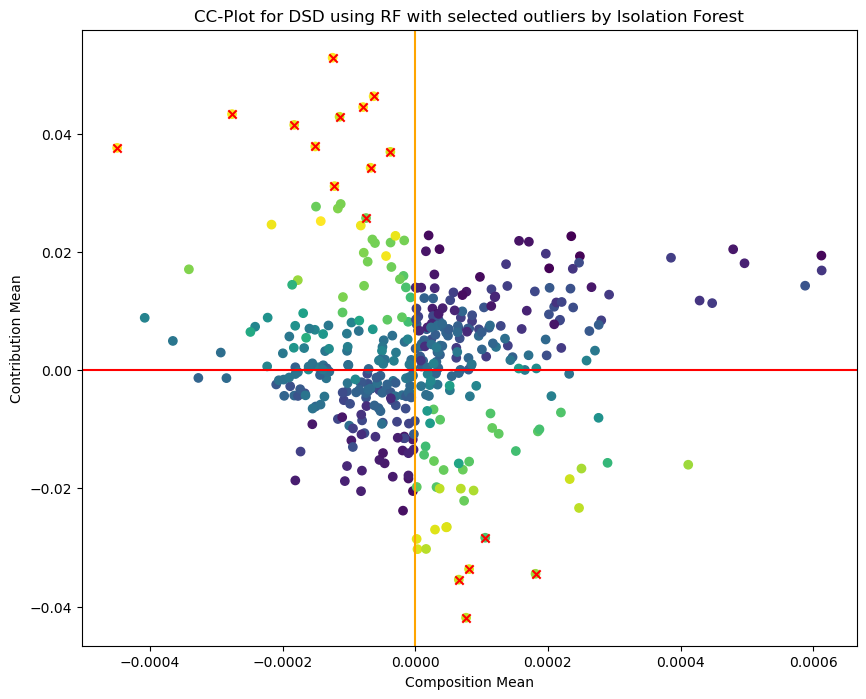

In [11]:
plt.figure(figsize=(10,8))


plt.title("CC-Plot for DSD using RF with selected outliers by Isolation Forest")
plt.xlabel("Composition Mean")
plt.ylabel("Contribution Mean")
plt.axhline(0, c='r')
plt.axvline(0, c='orange')
rf_outliers = np.argwhere(iforest_outliers_rf==-1).flatten()
plt.scatter(np.mean(data_rf_composition, axis=0), np.mean(data_rf_contribution, axis=1), c=Y)
plt.scatter(np.mean(data_rf_composition, axis=0)[rf_outliers], \
            np.mean(data_rf_contribution, axis=1)[rf_outliers], c='r', marker='x')

We tabulate these outliers by contribution in the table below and consider their material compositions, we see that the majority of the selected outliers are from the W (Tungsten) and Mo (Molybdenum) groups in the context of this analysis which is not adequately explained by sample sizes as plotted in the bar chart below.

We also plot the average contribution across each group of elements for their material compositions.

In [12]:
contribution_sorting_args = np.argsort(np.abs(np.mean(data_rf_contribution, axis=1)[rf_outliers]))
contribution_sorting_vals = np.sort(np.abs(np.mean(data_rf_contribution, axis=1)[rf_outliers]))

In [13]:
data.iloc[rf_outliers].iloc[contribution_sorting_args]

,Material compositions 1,Material compositions 2,Enorm (eV),E_raw (eV),Site2_MeltingT,Site1_MendeleevNumber,Site1_MiracleRadius,GSestFCClatcnt_max_value,Site2_BCCenergy_pa,Site1_BCCfermi,...,BCCenergy_pa_composition_average,MiracleRadius_min_value,MeltingT_min_value,NUnfilled_max_value,Site2_Group,Site1_CovalentRadii,Site2_NUnfilled,SpecificHeatCapacity_difference,Site1_Electronegativity,BCCenergy_pa_arithmetic_average
237,Mo,Zn,-0.07497,4.953829,0.132448,0.581081,0.184211,0.162802,0.922083,0.85129,...,0.573929,0.373737,0.132448,0.272727,0.733333,0.254237,0.000000,0.053864,0.753247,0.573929
224,Mo,Co,-0.43262,4.596179,0.443173,0.581081,0.184211,0.162802,0.467125,0.85129,...,0.333747,0.232323,0.443173,0.272727,0.533333,0.254237,0.136364,0.066745,0.753247,0.333747
391,W,Zn,-0.08791,5.959235,0.132448,0.594595,0.131579,0.172283,0.922083,0.66484,...,0.486787,0.333333,0.132448,0.272727,0.733333,0.254237,0.000000,0.100703,0.883117,0.486787
380,W,P,-0.30898,5.738165,0.023978,0.594595,0.131579,0.323754,0.646596,0.66484,...,0.341352,0.000000,0.023978,0.272727,0.933333,0.254237,0.136364,0.249415,0.883117,0.341352
372,W,Ge,-0.12059,5.926555,0.282338,0.594595,0.131579,0.332751,0.678214,0.66484,...,0.358043,0.121212,0.282338,0.272727,0.866667,0.254237,0.181818,0.074161,0.883117,0.358043
382,W,Pt,-0.76508,5.282065,0.522175,0.594595,0.131579,0.172283,0.549549,0.66484,...,0.290119,0.333333,0.522175,0.272727,0.600000,0.254237,0.090909,0.000000,0.883117,0.290119
361,W,Ag,-0.43404,5.613105,0.289137,0.594595,0.131579,0.179560,0.799972,0.66484,...,0.422322,0.333333,0.289137,0.272727,0.666667,0.254237,0.045455,0.040984,0.883117,0.422322
366,W,Cd,-0.32530,5.721845,0.103997,0.594595,0.131579,0.256562,0.954644,0.66484,...,0.503977,0.333333,0.103997,0.272727,0.733333,0.254237,0.000000,0.039813,0.883117,0.503977
360,W,W,0.00000,6.047145,1.000000,0.594595,0.131579,0.172283,0.000000,0.66484,...,0.000000,0.333333,1.000000,0.272727,0.333333,0.254237,0.272727,0.000000,0.883117,0.000000
376,W,Mg,-0.08800,5.959145,0.199001,0.594595,0.131579,0.330382,0.894223,0.66484,...,0.472079,0.333333,0.199001,0.272727,0.066667,0.254237,0.000000,0.347385,0.883117,0.472079


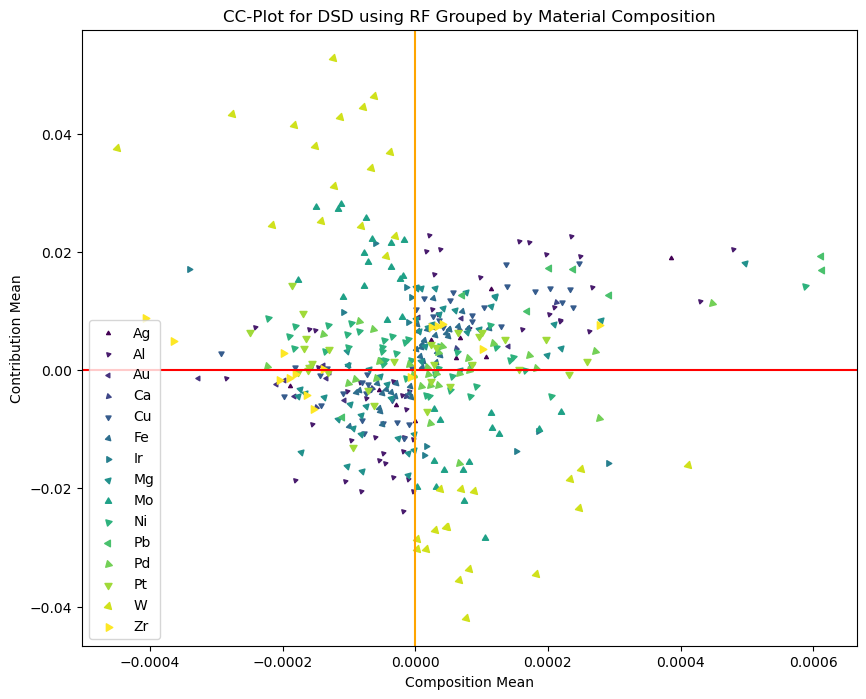

In [14]:
plt.figure(figsize=(10,8))

elements, counts = np.unique(data.iloc[:,0], return_counts=True)
sorted_counts = np.argsort(counts)

plt.title("CC-Plot for DSD using RF Grouped by Material Composition")
plt.xlabel("Composition Mean")
plt.ylabel("Contribution Mean")
plt.axhline(0, c='r')
plt.axvline(0, c='orange')

cmap = cm.get_cmap('viridis', len(elements))

color_count = 0
for e in elements:
    indices = np.where(data['Material compositions 1'] == e)    
    plt.scatter(np.mean(data_rf_composition, axis=0)[indices], np.mean(data_rf_contribution, axis=1)[indices]\
                ,color=cmap.colors[color_count], label=e, s=10 + color_count * 2, marker=(3, 0, color_count*45))
    
    color_count+=1
    
plt.legend()

In [15]:
np.unique(data.iloc[:,0])

array(['Ag', 'Al', 'Au', 'Ca', 'Cu', 'Fe', 'Ir', 'Mg', 'Mo', 'Ni', 'Pb',
       'Pd', 'Pt', 'W', 'Zr'], dtype=object)

Text(0.5, 0.98, 'CC Grouped by Material Composition 1 (Main)')

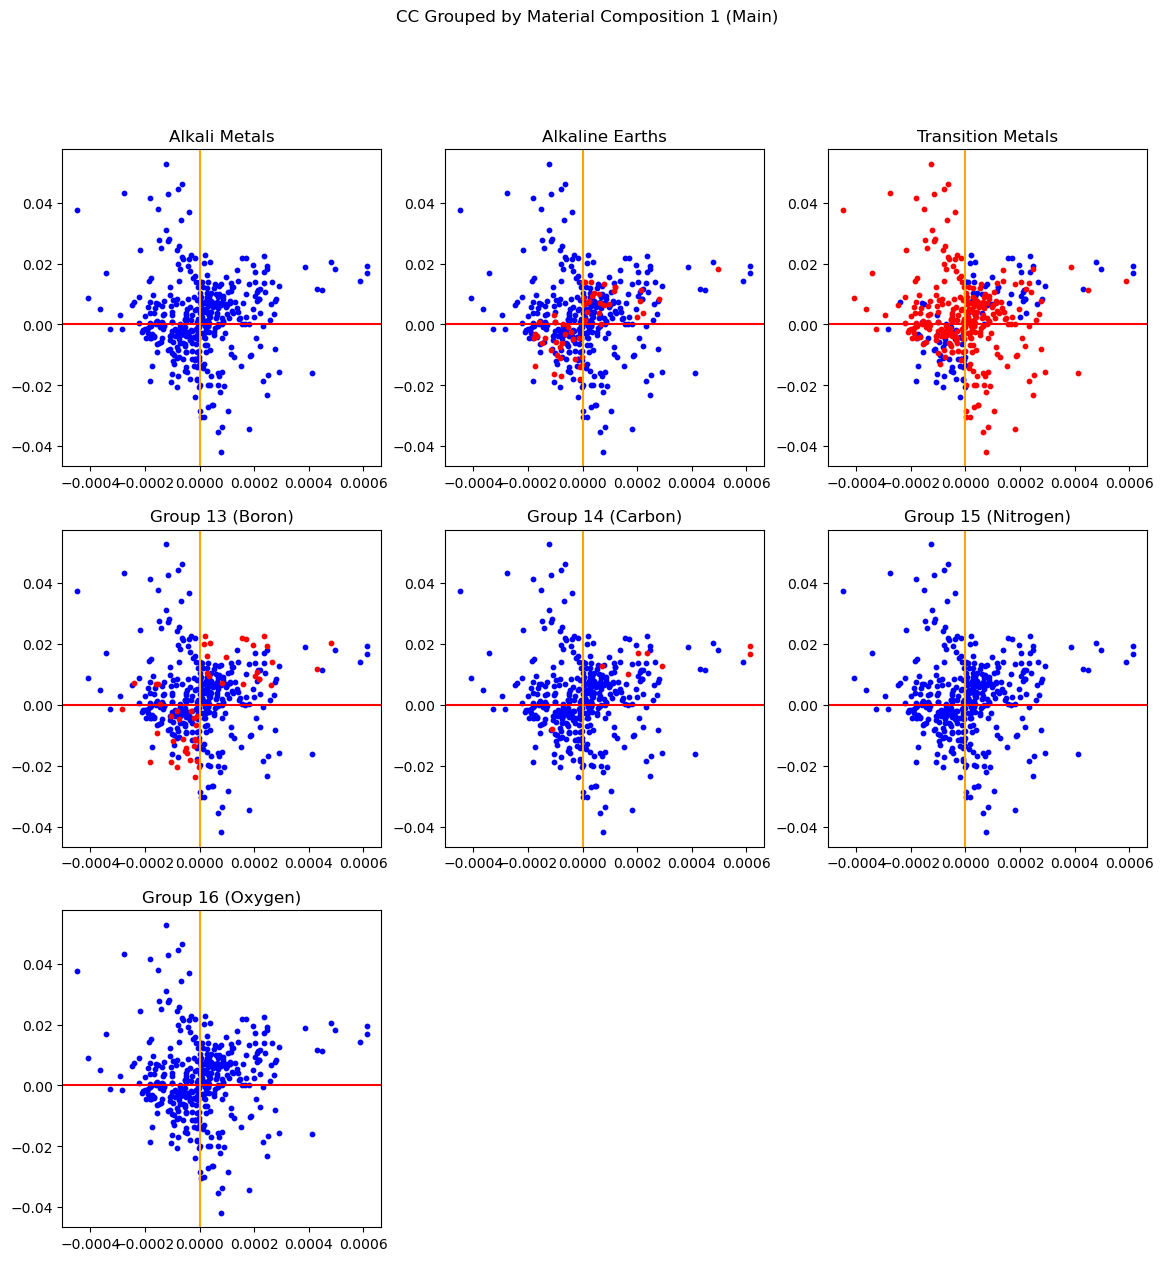

In [16]:
# Grouping by https://pubchem.ncbi.nlm.nih.gov/periodic-table/
d = data
i = 0
plt.figure(figsize=(14,14))

plt.subplot(333)

plt.title("Transition Metals")
transition_metals = ['Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zr', 'Nb', "Mo", 'Tc', "Ru", 'Rh', 'Pd', 'Ag', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au']
plot_group(transition_metals, d, i)

plt.subplot(332)

plt.title("Alkaline Earths")
halogens = ['Be', 'Mg', 'Ca', 'Sr', 'Ba', 'Ra']
plot_group(halogens, d, i)

plt.subplot(331)

plt.title("Alkali Metals")
alkali = ['Li', 'Na', 'K', 'Rb', 'Cs', 'Fr']
plot_group(alkali, d, i)

plt.subplot(334)

plt.title("Group 13 (Boron)")
G13 = ['B', 'Al', 'Ga', 'In', 'Tl', 'Nh']
plot_group(G13, d, i)

plt.subplot(335)

plt.title("Group 14 (Carbon)")
G14 = ['C', 'Si', 'Ge', 'Sn', 'Pb', 'Fl']
plot_group(G14, d, i)

plt.subplot(336)

plt.title("Group 15 (Nitrogen)")
G15 = ['N', 'P', 'As', 'Sb', 'Bi', 'Mc']
plot_group(G15, d, i)

plt.subplot(337)

plt.title("Group 16 (Oxygen)")
G16 = ['O', 'S', 'Se', 'Te', 'Po', 'Lv']
plot_group(G16, d, i)

plt.suptitle('CC Grouped by Material Composition 1 (Main)')

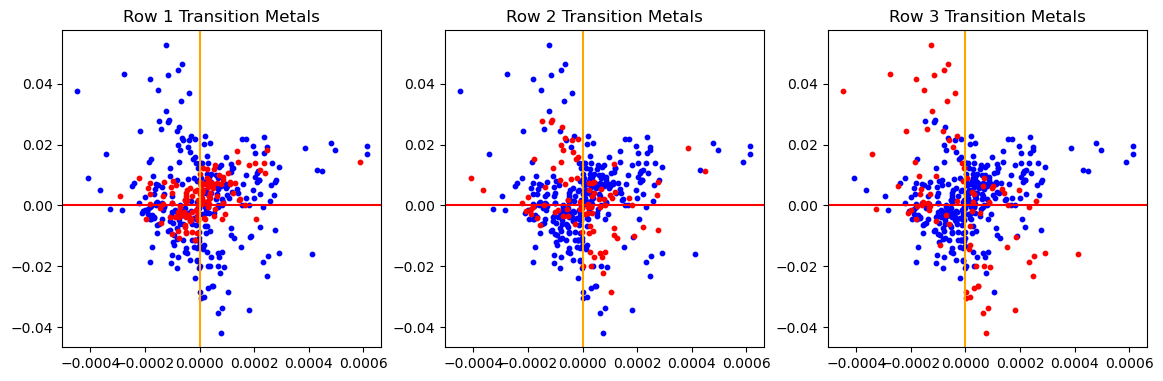

In [17]:
# Grouping by https://pubchem.ncbi.nlm.nih.gov/periodic-table/
d = data
i = 0
plt.figure(figsize=(14,14))

plt.subplot(331)

plt.title("Row 1 Transition Metals")
transition_metals = ['Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu']
plot_group(transition_metals, d, i)

plt.subplot(332)

plt.title("Row 2 Transition Metals")
halogens = ['Zr', 'Nb', "Mo", 'Tc', "Ru", 'Rh', 'Pd', 'Ag']
plot_group(halogens, d, i)

plt.subplot(333)

plt.title("Row 3 Transition Metals")
alkali = ['Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au']
plot_group(alkali, d, i)


Text(0.5, 0.98, 'CC Grouped by Material Composition 2 (Sub)')

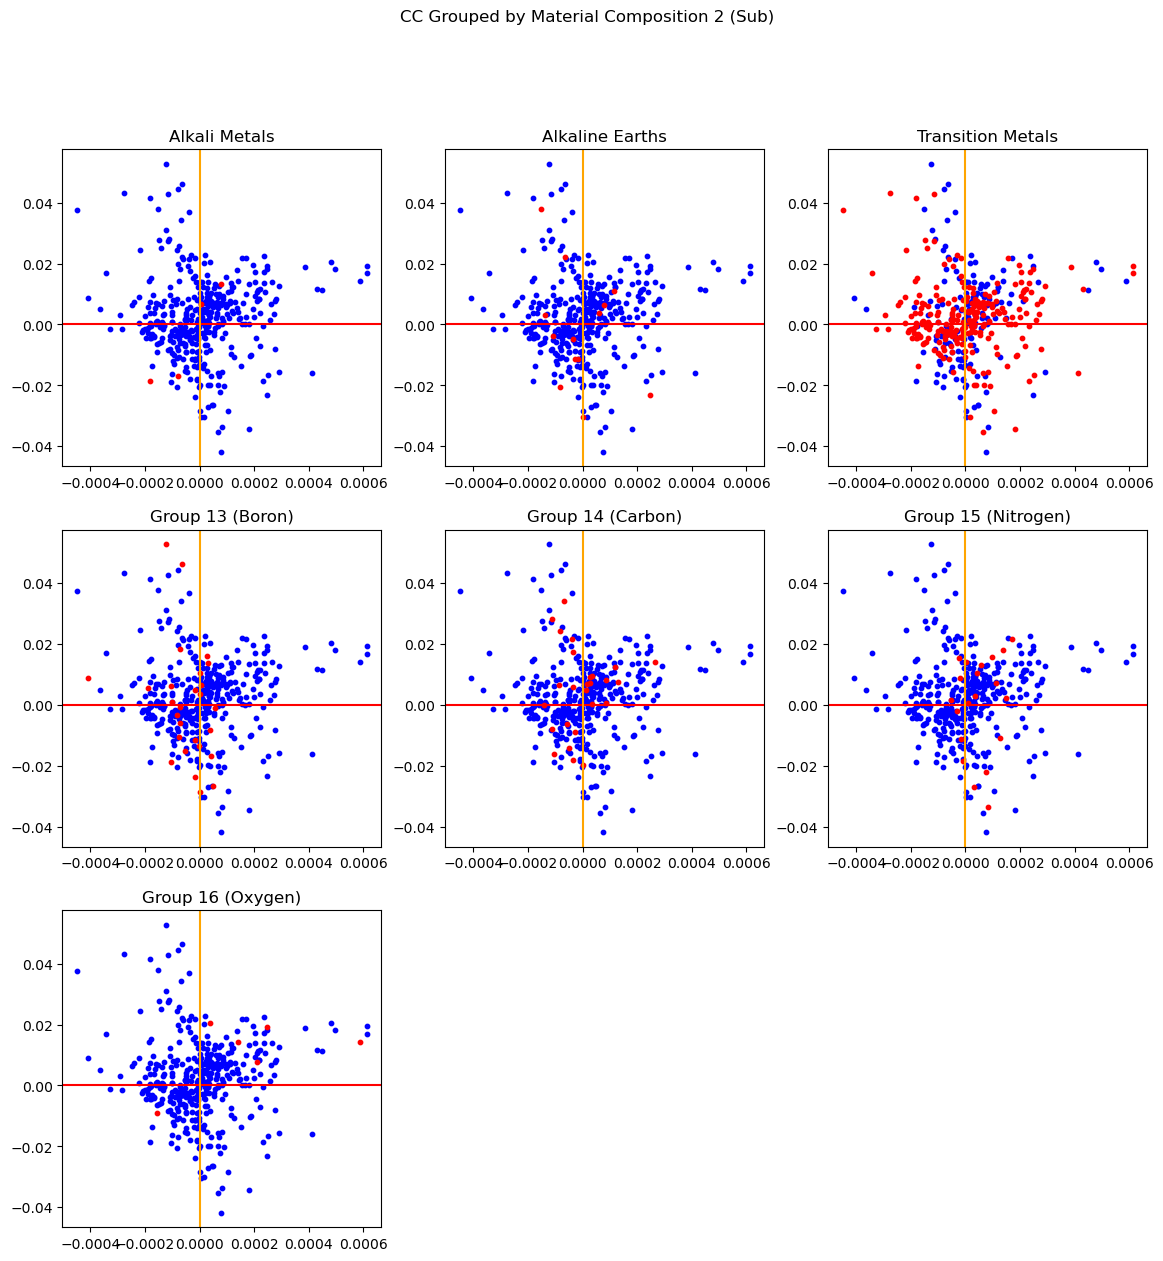

In [18]:
# Grouping by https://pubchem.ncbi.nlm.nih.gov/periodic-table/
d = data
i = 1
plt.figure(figsize=(14,14))

plt.subplot(333)

plt.title("Transition Metals")
transition_metals = ['Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zr', 'Nb', "Mo", 'Tc', "Ru", 'Rh', 'Pd', 'Ag', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au']
plot_group(transition_metals, d, i)

plt.subplot(332)

plt.title("Alkaline Earths")
G2 = ['Be', 'Mg', 'Ca', 'Sr', 'Ba', 'Ra']
plot_group(G2, d, i)

plt.subplot(331)

plt.title("Alkali Metals")
G1 = ['Li', 'Na', 'K', 'Rb', 'Cs', 'Fr']
plot_group(G1, d, i)

plt.subplot(334)

plt.title("Group 13 (Boron)")
G13 = ['B', 'Al', 'Ga', 'In', 'Tl', 'Nh']
plot_group(G13, d, i)

plt.subplot(335)

plt.title("Group 14 (Carbon)")
G14 = ['C', 'Si', 'Ge', 'Sn', 'Pb', 'Fl']
plot_group(G14, d, i)

plt.subplot(336)

plt.title("Group 15 (Nitrogen)")
G15 = ['N', 'P', 'As', 'Sb', 'Bi', 'Mc']
plot_group(G15, d, i)

plt.subplot(337)

plt.title("Group 16 (Oxygen)")
G16 = ['O', 'S', 'Se', 'Te', 'Po', 'Lv']
plot_group(G16, d, i)

plt.suptitle('CC Grouped by Material Composition 2 (Sub)')

Text(0.5, 0.98, 'CC of Transtion Metal rows by Material Composition 2 (Sub) ')

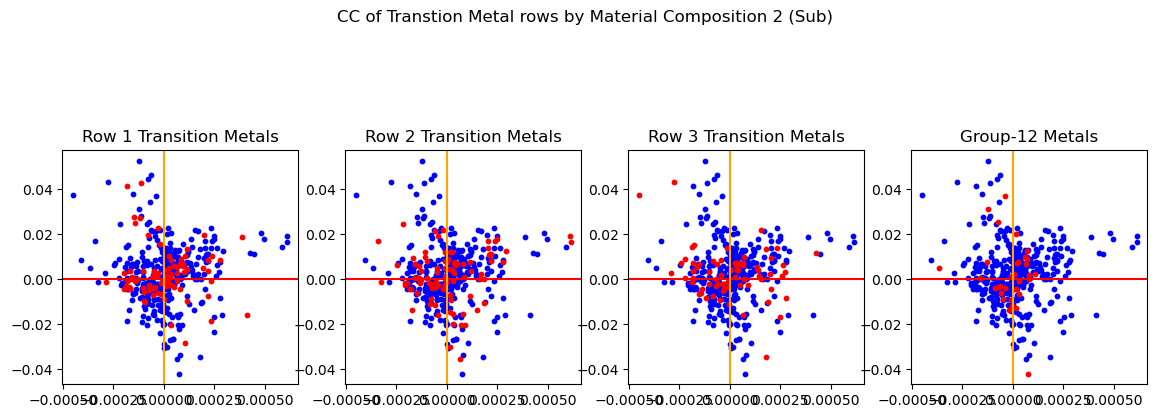

In [19]:
# Grouping by https://pubchem.ncbi.nlm.nih.gov/periodic-table/
d = data
i = 1
plt.figure(figsize=(14,14))

plt.subplot(441)

plt.title("Row 1 Transition Metals")
transition_metals = ['Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu']
plot_group(transition_metals, d, i)

plt.subplot(442)

plt.title("Row 2 Transition Metals")
halogens = ['Zr', 'Nb', "Mo", 'Tc', "Ru", 'Rh', 'Pd', 'Ag']
plot_group(halogens, d, i)

plt.subplot(443)

plt.title("Row 3 Transition Metals")
alkali = ['Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au']
plot_group(alkali, d, i)

plt.subplot(444)

plt.title("Group-12 Metals")
G12 = ['Zn', 'Cd', 'Hg']
plot_group(G12, d, i)

plt.suptitle('CC of Transtion Metal rows by Material Composition 2 (Sub) ')

Text(0.5, 0.98, 'CC of Transtion Metal Groups by Material Composition 2 (Sub) ')

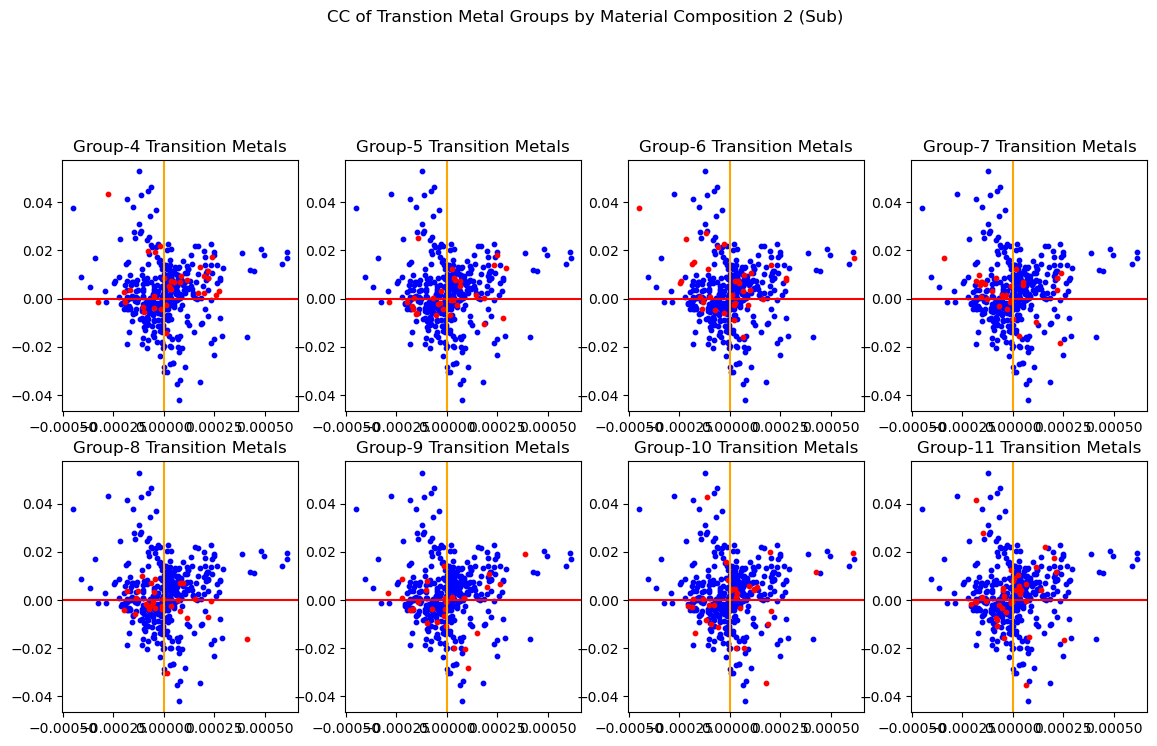

In [20]:
# Grouping by https://pubchem.ncbi.nlm.nih.gov/periodic-table/
d = data
i = 1
plt.figure(figsize=(14,15))

plt.subplot(441)

plt.title("Group-4 Transition Metals")
G4 = ['Ti', 'Zr', 'Hf', 'Rf']
plot_group(G4, d, i)

plt.subplot(442)

plt.title("Group-5 Transition Metals")
G5 = ['V', 'Nb', 'Ta', 'Db']
plot_group(G5, d, i)

plt.subplot(443)

plt.title("Group-6 Transition Metals")
G6 = ['Cr', 'Mo', 'W', 'Sg']
plot_group(G6, d, i)

plt.subplot(444)

plt.title("Group-7 Transition Metals")
G7 = ['Mn', 'Tc', 'Re', 'Bh']
plot_group(G7, d, i)

plt.subplot(445)

plt.title("Group-8 Transition Metals")
G8 = ['Fe', 'Ru', 'Os', 'Hs']
plot_group(G8, d, i)

plt.subplot(446)

plt.title("Group-9 Transition Metals")
G9 = ['Co', 'Rh', 'Ir', 'Mt']
plot_group(G9, d, i)

plt.subplot(447)

plt.title("Group-10 Transition Metals")
G10 = ['Ni', 'Pd', 'Pt', 'Ds']
plot_group(G10, d, i)

plt.subplot(448)

plt.title("Group-11 Transition Metals")
G11 = ['Cu', 'Ag', 'Au', 'Rg']
plot_group(G11, d, i)

plt.suptitle('CC of Transtion Metal Groups by Material Composition 2 (Sub) ')

<BarContainer object of 58 artists>

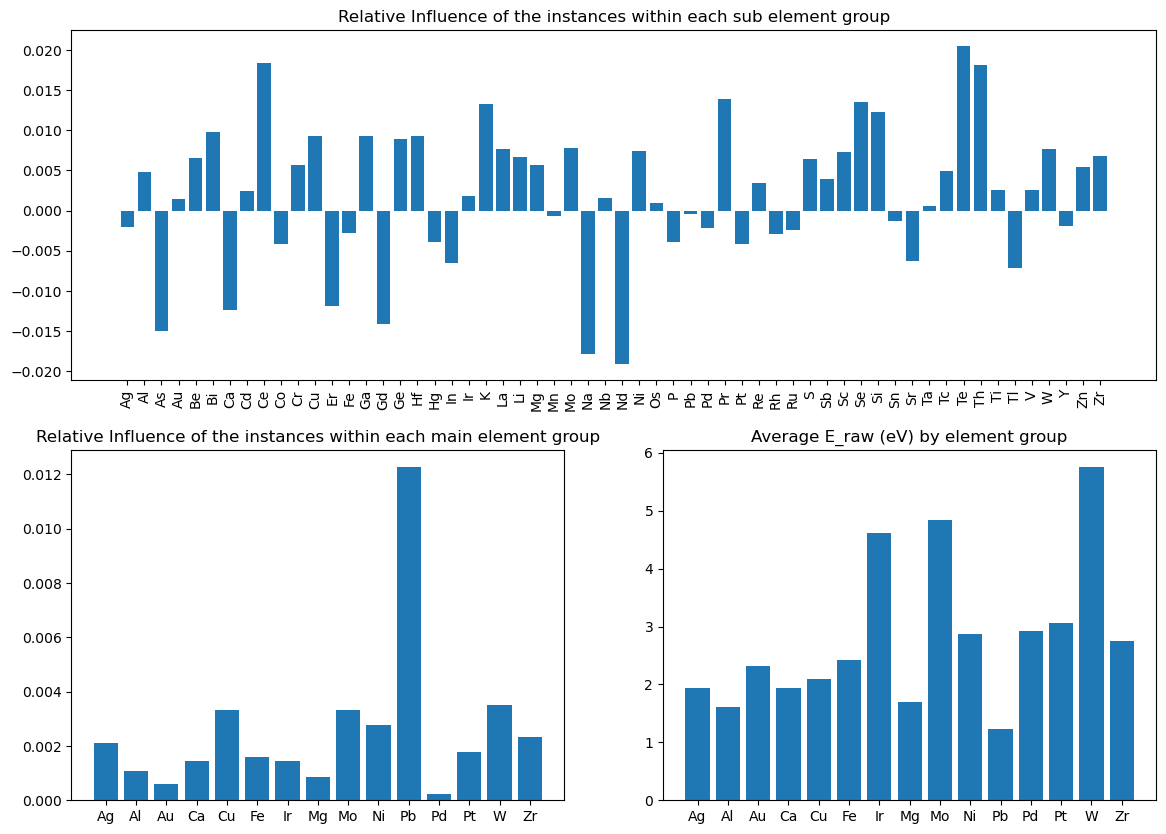

In [21]:
elements, counts = np.unique(data.iloc[:,0], return_counts=True)
sorted_counts = np.argsort(counts)

plt.figure(figsize=(14,10))

plt.subplot(223)

influence_vals = []

for e in elements:
    indices = np.where(data['Material compositions 1'] == e)
    influence_vals.append(np.mean(np.mean((data_rf_contribution)[indices], axis=0)))
    
plt.title("Relative Influence of the instances within each main element group")
plt.bar(elements, influence_vals)

plt.subplot(224)

influence_vals = []

for e in elements:
    indices = np.where(data['Material compositions 1'] == e)[0]
    influence_vals.append(np.mean(data['E_raw (eV)'][indices]))
    
plt.title("Average E_raw (eV) by element group")
plt.bar(elements, influence_vals)

plt.subplot(211)
plt.xticks(rotation=90)
elements, counts = np.unique(data.iloc[:,1], return_counts=True)
sorted_counts = np.argsort(counts)
influence_vals = []
for e in elements:
    indices = np.where(data['Material compositions 2'] == e)
    influence_vals.append(np.mean(np.mean((data_rf_contribution)[indices], axis=0)))
    
plt.title("Relative Influence of the instances within each sub element group")
plt.bar(elements, influence_vals)

In [22]:
from ELib import *

G_tmetals = [G1, G2, G3, G4, G5, G6, G7, G8, G9, G10, G11, G12, G13, G14, G15, G16]
G_metals_i = np.arange(1, len(G_tmetals)+1)
av_G_contributions = []

for GG in G_tmetals:
    g_indices = data[data.iloc[:,1].isin(GG)].index
    av_contribution = np.mean(np.mean(data_rf_contribution[g_indices], axis=1))
    av_G_contributions.append(av_contribution)

/home/users/u6409902/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/u6409902/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 0, 'Contribution of Element Groups')

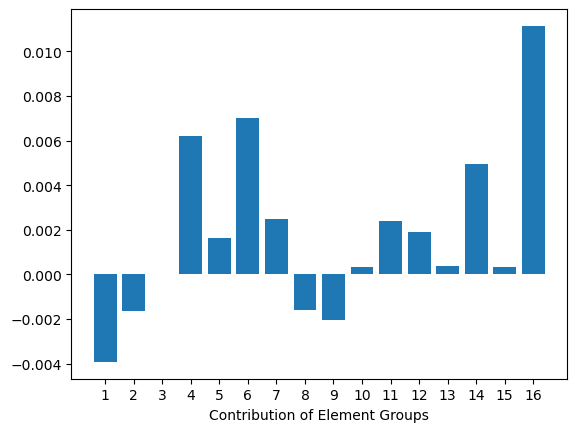

In [23]:
plt.xticks(G_metals_i)
plt.bar(G_metals_i, av_G_contributions)
plt.xlabel("Contribution of Element Groups")